## Music Classification
The main features that will be used to determine the similarity between two songs will be temp of the songs and when beats occur, the percussive rythm, and the sequence of notes played

In [1]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
from __future__ import print_function
import librosa

# 1. Load the audio as a waveform `y`, store the sampling rate as `sr`
y, sr = librosa.load("music files/2Pac - can't c me.wav")

In [77]:
print("Number of Samples: {:d}".format(y.shape[0]))
print("Sampling Rate is: {:d} samples/sec".format(sr))

Number of Samples: 7293072
Sampling Rate is: 22050 samples/sec


## Extract Tempo and Beat Instances

In [ ]:
# 2. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 3. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

#print('Saving output to beat_times.csv')
#librosa.output.times_csv('beat_times.csv', beat_times)

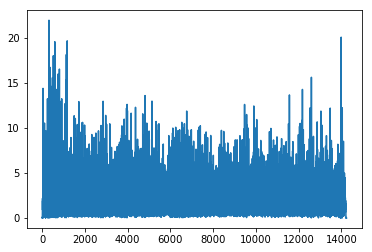

In [10]:
#4. Rhythm features - Tempogram

hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
plt.plot(oenv, label='Onset strength')

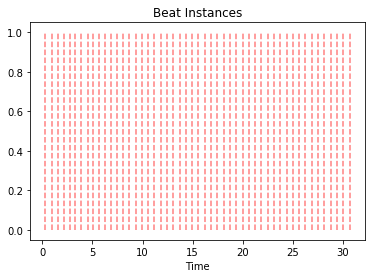

In [52]:
plt.vlines(beat_times[:50], 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats')
plt.title("Beat Instances")
plt.xlabel("Time")

### Extract Percussive Component 

In [ ]:
 # Extract harmonic and percussive components
 y_harmonic, y_percussive = librosa.effects.hpss(y, margin=(1.0,5.0))

In [3]:
import IPython.display as ipd
print(y.shape)
#Play a bit of the song
ipd.Audio(y[500000:1000000], rate=sr) 

(7293072,)


In [54]:
#Play the percussive component
ipd.Audio(y_percussive[500000:1000000], rate=sr) 

### Extract Chroma Data

In [5]:
import librosa.display
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

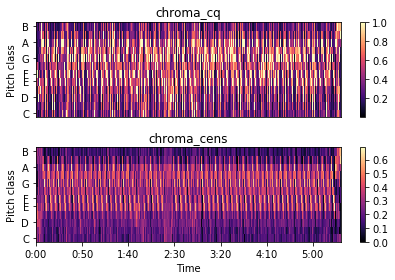

In [58]:
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('chroma_cq')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()
plt.tight_layout()

## Repeat to a Few Frames of Training Data
First we load the expected song similarity rating that is from 0-4

In [4]:
import pandas as pd
df = pd.read_excel('Song Correlation.xlsx')

In [79]:
df.head()

Nirvana -  Heart Shaped Box  \
Nirvana -  Heart Shaped Box                                  4.0   
Alice in Chains - Rooster                                    NaN   
Chic - Le Freak                                              NaN   
Wild Cherry - Play that Funky Music                          NaN   
Snoop Dogg - who am i                                        NaN   

                                     Alice in Chains - Rooster  \
Nirvana -  Heart Shaped Box                                4.0   
Alice in Chains - Rooster                                  4.0   
Chic - Le Freak                                            NaN   
Wild Cherry - Play that Funky Music                        NaN   
Snoop Dogg - who am i                                      NaN   

                                     Chic - Le Freak  \
Nirvana -  Heart Shaped Box                      2.0   
Alice in Chains - Rooster                        2.0   
Chic - Le Freak                                  4.0   
Wild Cherry - Play that Funky Music              NaN   
Snoop Dogg - who am i                            NaN   

                                     Wild Cherry - Play that Funky Music  \
Nirvana -  Heart Shaped Box                                          2.0   
Alice in Chains - Rooster                                            2.0   
Chic - Le Freak                                                      4.0   
Wild Cherry - Play that Funky Music                                  4.0   
Snoop Dogg - who am i                                                NaN   

                                     Snoop Dogg - who am i  2Pac - can't c me  \
Nirvana -  Heart Shaped Box                            0.0                0.0   
Alice in Chains - Rooster                              0.0                0.0   
Chic - Le Freak                                        1.0                0.0   
Wild Cherry - Play that Funky Music                    0.0                0.0   
Snoop Dogg - who am i                                  4.0                4.0   

                                     Chicago - 25 or 6 to 4  \
Nirvana -  Heart Shaped Box                             2.0   
Alice in Chains - Rooster                               2.0   
Chic - Le Freak                                         1.0   
Wild Cherry - Play that Funky Music                     2.0   
Snoop Dogg - who am i                                   0.0   

                                     Green Day - Brain Stew  Beck G - Mayores  \
Nirvana -  Heart Shaped Box                             3.0               0.0   
Alice in Chains - Rooster                               3.0               0.0   
Chic - Le Freak                                         1.0               1.0   
Wild Cherry - Play that Funky Music                     1.0               1.0   
Snoop Dogg - who am i                                   0.0               1.0   

                                     Maluma - Felices los 4  
Nirvana -  Heart Shaped Box                               0  
Alice in Chains - Rooster                                 0  
Chic - Le Freak                                           1  
Wild Cherry - Play that Funky Music                       1  
Snoop Dogg - who am i                                     0

In [12]:
df.columns.values

Nirvana -  Heart Shaped Box


In [55]:
# Frame size 
nfft = 22050
print('Number of frames: ' + str(round(y.shape[0]/nfft)))

Number of frames: 284


In [99]:
x = []
for i, song in enumerate(df.columns.values):
    y, sr = librosa.load("music files/" + song + ".wav")
    
    # take frames to do calculations of the middle of a song, after any intros
    nframe = 60
    ycrop = y[nframe*nfft:(nframe+40)*nfft]
    
    # tempo features
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]
    
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)
    chroma_cq = np.ravel(chroma_cq) # flatten the 12 rows

    # predictor
    xi = np.hstack([tempo, beat_times, y_percussive, chroma_cq])
    x.append(xi)
    

In [122]:
#TODO: it seems each x array for each song isnt the same shape so the reason for this should be found out

xa = np.array(x)
print(x[9].shape)

(902800,)


In [59]:
   
    
    # testing stuff
    
    y, sr = librosa.load("music files/Nirvana -  Heart Shaped Box.wav")
    
    # Convert to floating point values so that compuations below do not overflow
y = y.astype(float)
    
    # take 2nd frame to do calculations of the middle of a song, after any intros
    # Frame size
nfft = 22050
    nframe = 2
    ycrop = y[nframe*nfft:(nframe+1)*nfft]
    


    

    



In [61]:
nfft = 22050
nframe = 60
ycrop = y[nframe*nfft:(nframe+40)*nfft]

In [62]:
    # tempo features
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)

In [63]:
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]

In [58]:
print(y.shape)
print(y)
import IPython.display as ipd
print(y.shape)
#Play a bit of the song
ipd.Audio(y[60*nfft:100*nfft], rate=sr) 
#plt.plot(y[60*nfft:120*nfft])

(6266512,)
[ 0.  0.  0. ...,  0.  0.  0.]
(6266512,)


In [64]:
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)

In [85]:
    print(tempo)
    print(beat_times.shape)
    print(y_percussive.shape)
    chroma_cq = np.ravel(chroma_cq)
    print(chroma_cq.shape)
    xtst = np.hstack([tempo, beat_times, y_percussive, chroma_cq])
    print(xtst.shape)


99.3840144231
(66,)
(882000,)
(20676,)
(902743,)


In [ ]:
val = []
for i, song in enumerate(df.columns.values):